In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import MARBLE
from MARBLE import plotting, dynamics, geometry


np.random.seed(42)

In [2]:
def get_pos_vel(mus, alpha=0.05):
    X0_range = dynamics.initial_conditions(n, len(mus), area)

    pos, vel = [], []
    for X0, m in zip(X0_range, mus):
        p, v = dynamics.simulate_vanderpol(m, X0, t)
        pos.append(np.vstack(p))
        vel.append(np.vstack(v))

    pos, vel = dynamics.embed_parabola(pos, vel, alpha=alpha)
    return pos, vel

# Generate phase portraits from random initial conditions while varying $\beta_1$

In [3]:
n_mus = 51
t = np.arange(0, 3, 0.5)
n = 100
area = [[-3, -3],[3, 3]]

mus = np.linspace(-1.0, 1.0, n_mus)
pos, vel = get_pos_vel(mus)

/Users/arnaudon/base/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


10000


/Users/arnaudon/base/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


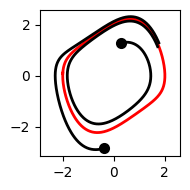

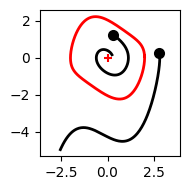

In [69]:
# simulate some long trajectories to plot attractor
t_long = np.arange(0, 100, 0.01)
print(len(t_long))
mus_long = [0.5, 0.5, 0.5, -0.5, -0.5, -0.5]#, 0.5]
X0 = dynamics.initial_conditions(1, len(mus_long), area)
p_long, v_long = [], []
for X0, m in zip(X0, mus_long):
    p, v = dynamics.simulate_vanderpol(m, X0, t_long, keep_v=True)
    p_long.append(p[0])
    v_long.append(v[0])


plt.figure(figsize=(2, 2))
plt.plot(p_long[0][-640:, 0], p_long[0][-640:, 1], '-', c='r', lw=2)
plt.scatter(p_long[0][0, 0], p_long[0][0, 1], c='k', lw=2)
plt.plot(p_long[0][:700, 0], p_long[0][:700, 1], '-', c='k', lw=2)
plt.scatter(p_long[2][0, 0], p_long[2][0, 1], c='k', lw=2)
plt.plot(p_long[2][:400, 0], p_long[2][:400, 1], '-', c='k', lw=2)


plt.axis('equal')
plt.tight_layout()


plt.savefig('traj_stable.pdf')


plt.figure(figsize=(2, 2))
plt.scatter(0, 0, c='r', marker='+')
plt.plot(-p_long[0][-640:, 0], p_long[0][-640:, 1], '-', c='r', lw=2)
plt.scatter(p_long[3][0, 0], p_long[3][0, 1], c='k', lw=2)
plt.plot(p_long[3][:700, 0], p_long[3][:700, 1], '-', c='k', lw=2)
plt.scatter(p_long[4][0, 0], p_long[4][0, 1], c='k', lw=2)
plt.plot(p_long[4][:180, 0], p_long[4][:180, 1], '-', c='k', lw=2)


plt.axis('equal')
plt.tight_layout()
plt.savefig('traj_unstable.pdf')

In [5]:
data = MARBLE.construct_dataset(pos, features=vel, k=20, stop_crit=0.03, local_gauges=False)

---- Embedding dimension: 3
---- Signal dimension: 3


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 


# Run MARBLE

In [6]:

params = {'epochs': 50, #optimisation epochs
       'order': 2, #order of derivatives
       'hidden_channels': 32, #number of internal dimensions in MLP
       'out_channels': 5,
       'inner_product_features': True,
      }

model = MARBLE.net(data, loadpath='model_large', params=params)
#model.run_training(data, outdir='model_large')
#model.load_model('model_large')


---- Settings: 

epochs : 50
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  731


Performed umap embedding on embedded results.
[8.48999743e-01 1.15509344e-01 1.68108676e-02 5.29163227e-03
 1.39442947e-03 9.66933463e-04 8.61636146e-04 6.62187683e-04
 5.88449504e-04 5.37315215e-04 5.20476966e-04 4.20755674e-04
 3.63684040e-04 3.51288451e-04 3.34260151e-04 3.12275557e-04
 3.00525140e-04 2.88770927e-04 2.71757761e-04 2.55519473e-04]
Performed PCA embedding on embedded results.


<Figure size 640x480 with 0 Axes>

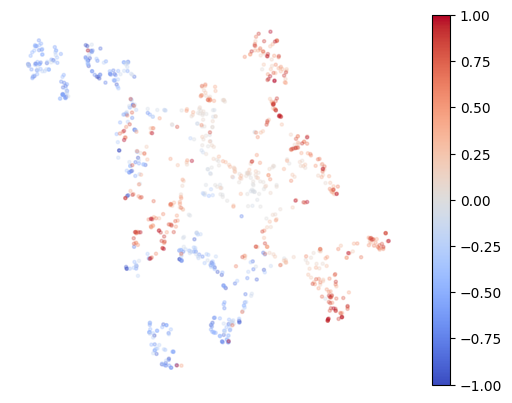

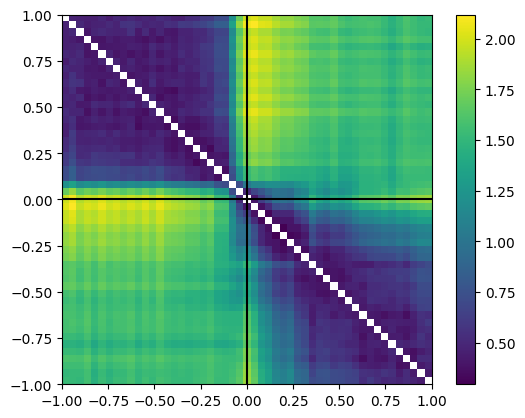

<Figure size 640x480 with 0 Axes>

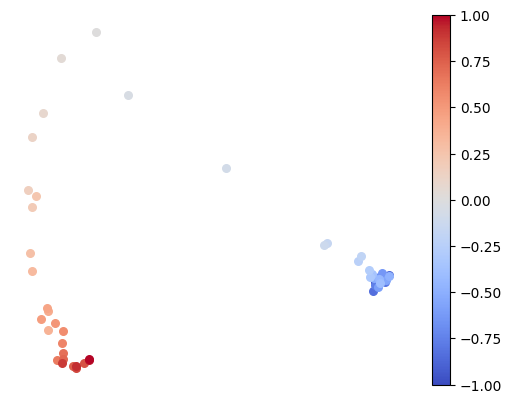

In [7]:
data = model.evaluate(data)
data = MARBLE.cluster_embeddings(data)

plt.figure()
plotting.embedding(data, mus[data.y.numpy().astype(int)])
plt.savefig('model_large_emb.pdf')

plt.figure()
d= data.dist.copy()
d += np.diag(np.diag(d) *np.nan)
im = plt.imshow(d, extent=[mus[0], mus[-1], mus[0], mus[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')

plt.colorbar(im)
plt.savefig('model_large_dist.pdf')

manifold = PCA(n_components=20)
manifold.fit(data.dist)
print(manifold.explained_variance_ratio_)
emb_MDS, _ = geometry.embed(data.dist, embed_typ='PCA', dim_emb=10, manifold=manifold)

plt.figure()
plotting.embedding(emb_MDS[:, :2], mus, s=30, alpha=1)
plt.savefig('model_large_dist_emb.pdf')


# Zoom on mu=0

In [8]:
mus = np.linspace(-0.1, 0.1, n_mus)
pos, vel = get_pos_vel(mus)

data = MARBLE.construct_dataset(pos, features=vel, k=20, stop_crit=0.03, local_gauges=False)
model = MARBLE.net(data, params=params, loadpath='model_zoom')
#model.run_training(data, outdir='model_zoom')

/Users/arnaudon/base/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


---- Embedding dimension: 3
---- Signal dimension: 3


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 

---- Settings: 

epochs : 50
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  731


Performed umap embedding on embedded results.
[7.55744282e-01 1.48010603e-01 5.81764571e-02 5.67037274e-03
 2.80350680e-03 2.10037459e-03 1.94587014e-03 1.75641729e-03
 1.28886898e-03 1.19410590e-03 1.08201446e-03 9.37842577e-04
 9.07693378e-04 8.69280491e-04 8.14528521e-04 7.83407885e-04
 7.73890742e-04 7.11376832e-04 6.73889072e-04 6.57435854e-04]
Performed PCA embedding on embedded results.


<Figure size 640x480 with 0 Axes>

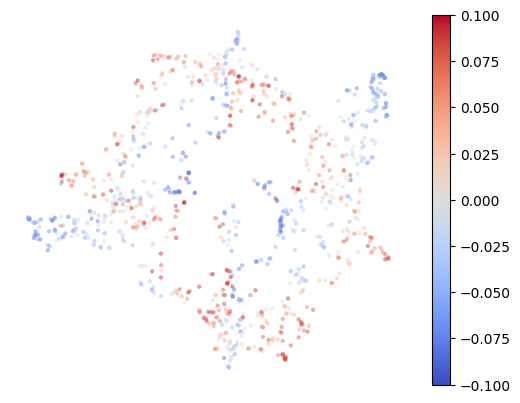

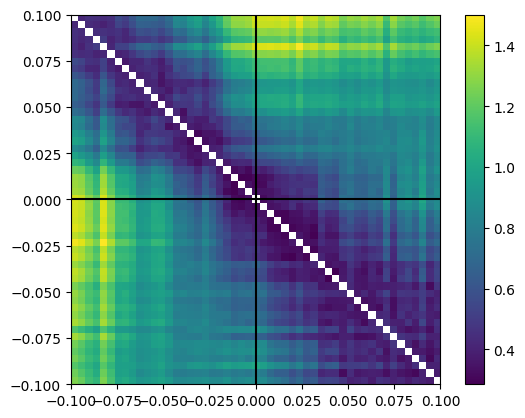

<Figure size 640x480 with 0 Axes>

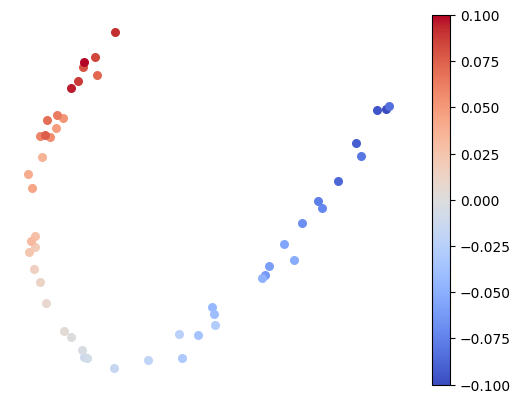

In [9]:
data = model.evaluate(data)
data = MARBLE.cluster_embeddings(data)

plt.figure()
plotting.embedding(data, mus[data.y.numpy().astype(int)])
plt.savefig('model_zoom_emb.pdf')

d= data.dist.copy()
d += np.diag(np.diag(d) *np.nan)
plt.figure()
im = plt.imshow(d, extent=[mus[0], mus[-1], mus[0], mus[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')

plt.colorbar(im)

plt.savefig('model_zoom_dist.pdf')

manifold = PCA(n_components=20)
manifold.fit(data.dist)
print(manifold.explained_variance_ratio_)
emb_MDS, _ = geometry.embed(data.dist, embed_typ='PCA', dim_emb=10, manifold=manifold)

plt.figure()
plotting.embedding(emb_MDS[:, :2], mus, s=30, alpha=1)
plt.savefig('model_zoom_dist_emb.pdf')


# Change of parabola curvature

In [10]:
def get_pos_vel(mus, alpha=0.05):
    X0_range = dynamics.initial_conditions(n, len(mus), area)

    pos, vel = [], []
    for X0, m in zip(X0_range, mus):
        p, v = dynamics.simulate_vanderpol(m, X0, t)
        a = np.random.uniform(-alpha, alpha)
        p, v = dynamics.embed_parabola(p, v, alpha=a)
        pos.append(np.vstack(p))
        vel.append(np.vstack(v))
   
    return pos, vel

In [11]:
mus = np.linspace(-0.1, 0.1, n_mus)
pos, vel = get_pos_vel(mus, alpha=0.2)

data = MARBLE.construct_dataset(pos, features=vel, k=20, stop_crit=0.03, local_gauges=False)


params['inner_product_features'] = True


model = MARBLE.net(data, params=params, loadpath='model_noise_inner')
#model.run_training(data, outdir='model_noise_inner')

/Users/arnaudon/base/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


---- Embedding dimension: 3
---- Signal dimension: 3


---- Computing kernels ... Done 
---- Computing eigendecomposition ... Done 

---- Settings: 

epochs : 50
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : True
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  13
---- Total number of parameters:  731


Performed umap embedding on embedded results.
[0.74510364 0.17040326 0.03606954 0.00595307 0.00402239 0.00298758
 0.002807   0.00205037 0.00180746 0.0016914  0.00154712 0.00138143
 0.001279   0.00121269 0.00112036 0.00104468 0.00098571 0.00092839
 0.00091372 0.00087485]
Performed PCA embedding on embedded results.


<Figure size 640x480 with 0 Axes>

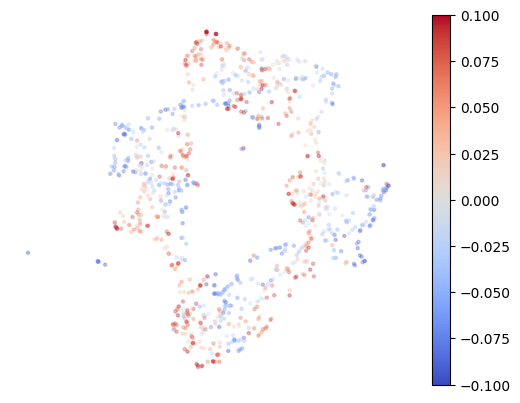

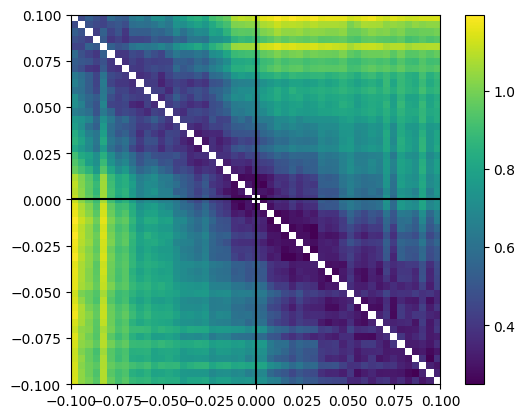

<Figure size 640x480 with 0 Axes>

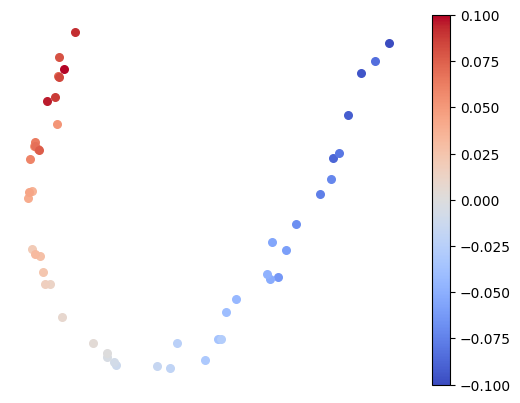

In [12]:
data = model.evaluate(data)
data = MARBLE.cluster_embeddings(data)

plt.figure()
plotting.embedding(data, mus[data.y.numpy().astype(int)])
plt.savefig('model_noise_inner_emb.pdf')

d= data.dist.copy()
d += np.diag(np.diag(d) *np.nan)
plt.figure()
im = plt.imshow(d, extent=[mus[0], mus[-1], mus[0], mus[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')

plt.colorbar(im)
plt.savefig('model_noise_inner_dist.pdf')

manifold = PCA(n_components=20)
manifold.fit(data.dist)
print(manifold.explained_variance_ratio_)
emb_MDS, _ = geometry.embed(data.dist, embed_typ='PCA', dim_emb=10, manifold=manifold)

plt.figure()
plotting.embedding(emb_MDS[:, :2], mus, s=30, alpha=1)
plt.savefig('model_noise_inner_dist_emb.pdf')


# again but without geometry aware

In [13]:
params['inner_product_features'] = False


model = MARBLE.net(data, params=params, loadpath='model_noise_no_inner')
#model.run_training(data, outdir='model_noise_no_inner')


---- Settings: 

epochs : 50
order : 2
hidden_channels : 32
out_channels : 5
inner_product_features : False
batch_size : 64
lr : 0.01
momentum : 0.9
diffusion : False
include_positions : False
frac_sampled_nb : -1
dropout : 0.0
n_lin_layers : 2
bias : True
vec_norm : False
batch_norm : None
seed : 0
processes : 1
dim_signal : 3
dim_emb : 3
n_sampled_nb : -1

---- Number of features to pass to the MLP:  39
---- Total number of parameters:  1446


Performed umap embedding on embedded results.
[0.6952687  0.15775699 0.03229317 0.01743417 0.0074593  0.00693285
 0.0054229  0.00486968 0.00420044 0.00365879 0.00333061 0.00322258
 0.0029861  0.00287965 0.0025073  0.0024036  0.00227444 0.00223705
 0.00218281 0.00208641]
Performed PCA embedding on embedded results.


<Figure size 640x480 with 0 Axes>

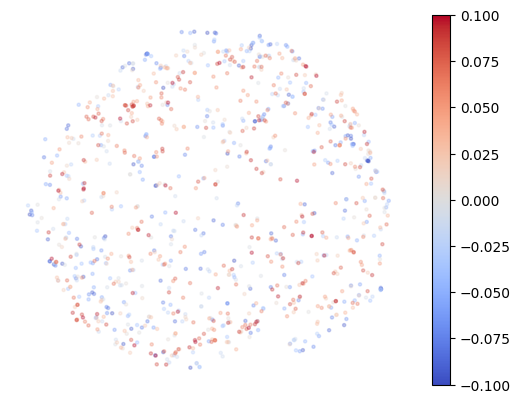

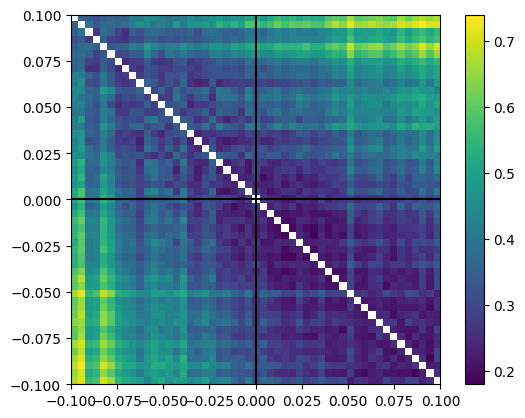

<Figure size 640x480 with 0 Axes>

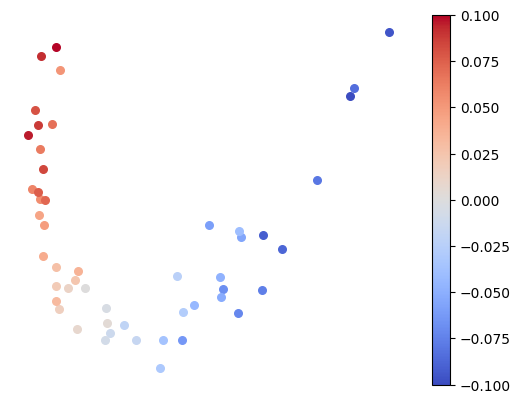

In [14]:
data = model.evaluate(data)
data = MARBLE.cluster_embeddings(data)

plt.figure()
plotting.embedding(data, mus[data.y.numpy().astype(int)])
plt.savefig('model_noise_no_inner_emb.pdf')

d= data.dist.copy()
d += np.diag(np.diag(d) *np.nan)
plt.figure()
im = plt.imshow(d, extent=[mus[0], mus[-1], mus[0], mus[-1]])
plt.axhline(0, c='k')
plt.axvline(0, c='k')

plt.colorbar(im)
plt.savefig('model_noise_no_inner_dist.pdf')


manifold = PCA(n_components=20)
manifold.fit(data.dist)
print(manifold.explained_variance_ratio_)
emb_MDS, _ = geometry.embed(data.dist, embed_typ='PCA', dim_emb=10, manifold=manifold)

plt.figure()
plotting.embedding(emb_MDS[:, :2], mus, s=30, alpha=1)
plt.savefig('model_noise_no_inner_dist_emb.pdf')
